<a href="https://colab.research.google.com/github/zia207/Survival_Analysis_R/blob/main/Colab_Notebook/02_07_06_03_survival_analysis_causal_effects_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![All-test](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 6.3 Causal Effects from Joint Models {.unnumbered}


This tutorial demonstrates how to estimate **causal effects** of time-varying treatments or exposures using **joint models** fitted with the `{JMbayes2}` R package. We’ll use the **Mayo Clinic Primary Biliary Cirrhosis (`pbc2`)** dataset as a running example. The tutorial covers:

1. **Causal Effects from Joint Models**  
2. **Conditional Causal Effects**  
3. **Marginal Causal Effects**  
4. **Marginal–Conditional Causal Effects**  
5. **Summary and Conclusion**  
6. **Resources**


## Overview


In longitudinal studies, time-varying confounding and feedback between biomarkers and outcomes complicate causal inference. **Joint models** simultaneously model:

- A **longitudinal submodel** (e.g., biomarker trajectory)

- A **survival submodel** (e.g., time to death/transplant)

By linking these via shared random effects, joint models can be used to simulate **counterfactual outcomes** under hypothetical treatment scenarios—enabling estimation of **causal effects**.

> **Key idea**: Compare expected survival under two treatment regimes (e.g., always treated vs. never treated), adjusting for time-varying confounders via the longitudinal process.


## Setup R in Python Runtype - Install {rpy2}
{rpy2} is a Python package that provides an interface to the R programming language, allowing Python users to run R code, call R functions, and manipulate R objects directly from Python. It enables seamless integration between Python and R, leveraging R's statistical and graphical capabilities while using Python's flexibility. The package supports passing data between the two languages and is widely used for statistical analysis, data visualization, and machine learning tasks that benefit from R's specialized libraries.

In [ ]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.5.1
Uninstalling rpy2-3.5.1:
  Successfully uninstalled rpy2-3.5.1
  Using cached rpy2-3.5.1-cp312-cp312-linux_x86_64.whl


## Mount Google Drive

In [ ]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Install Required R Packages


Following R packages are required to run this notebook. If any of these packages are not installed, you can install them using the code below:


In [ ]:
%%R
packages <-c(
		 'tidyverse',
		 'survival',
		 'survminer',
		 'ggsurvfit',
		 'tidycmprsk',
		 'ggfortify',
		 'timereg',
		 'cmprsk',
		 'condSURV',
		 'riskRegression',
		 'prodlim',
		 'lava',
		 'mstate',
		 'regplot',
		 'cmprskcoxmsm',
		 'GLMMadaptive',
		 'nlme',
		 'lme4',
		 'lattice',
		 'JM',
		 'joineR',
		 'joineRML',
		 'JMbayes2',
		 'patchwork'
		 )


### Install missing packages

In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(packages %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')
devtools::install_github("ItziarI/WeDiBaDis", lib='drive/My Drive/R/')


### Verify Installation

In [ ]:
%%R
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:


  method        from 
  nobs.multinom broom

  method         from 
  augment.mjoint broom
  glance.mjoint  broom
  tidy.mjoint    broom



     tidyverse       survival      survminer      ggsurvfit     tidycmprsk 
          TRUE           TRUE           TRUE           TRUE           TRUE 
     ggfortify        timereg         cmprsk       condSURV riskRegression 
          TRUE           TRUE           TRUE           TRUE           TRUE 
       prodlim           lava         mstate        regplot   cmprskcoxmsm 
          TRUE           TRUE           TRUE           TRUE           TRUE 
  GLMMadaptive           nlme           lme4        lattice             JM 
          TRUE           TRUE           TRUE           TRUE           TRUE 
        joineR       joineRML       JMbayes2 
          TRUE           TRUE           TRUE 


### Load Packages

In [ ]:
%%R
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))

In [ ]:
%%R
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])

Successfully loaded packages:
 [1] "package:JMbayes2"       "package:joineRML"       "package:joineR"        
 [4] "package:JM"             "package:splines"        "package:MASS"          
 [7] "package:lattice"        "package:lme4"           "package:Matrix"        
[10] "package:nlme"           "package:GLMMadaptive"   "package:cmprskcoxmsm"  
[13] "package:regplot"        "package:mstate"         "package:lava"          
[16] "package:prodlim"        "package:riskRegression" "package:condSURV"      
[19] "package:cmprsk"         "package:timereg"        "package:ggfortify"     
[22] "package:tidycmprsk"     "package:ggsurvfit"      "package:survminer"     
[25] "package:ggpubr"         "package:survival"       "package:lubridate"     
[28] "package:forcats"        "package:stringr"        "package:dplyr"         
[31] "package:purrr"          "package:readr"          "package:tidyr"         
[34] "package:tibble"         "package:ggplot2"        "package:tidyverse"     
[37] "pack

### Load data


We use `pbc2` dataset from the `JMbayes2` package, which contains follow up of 312 randomised patients with primary biliary cirrhosis, a rare autoimmune liver disease, at Mayo Clinic.

The `pbc` data is a well-known longitudinal dataset originally collected to study the natural history and treatment effects in patients with primary biliary cirrhosis, a chronic liver disease. The data have been widely used in survival analysis, joint modeling of longitudinal and time-to-event data, and mixed-effects modeling.

There are two main versions of this dataset:

1.  `pbc` – A baseline (cross-sectional) version containing one record per patient, used primarily for survival analysis.

2.  `pbc2` – A **longitudinal** version that includes repeated measurements over time for each patient, making it suitable for joint modeling of longitudinal biomarkers (e.g., serum bilirubin, albumin) and survival outcomes (e.g., time to death or liver transplantation).

Key Features of `pbc2`:

-   **Patients**: 312 individuals randomized to either D-penicillamine or placebo in a clinical trial.
-   **Repeated measures**: Multiple visits per patient (up to 17 visits), with lab values and clinical assessments recorded over time.
-   **Time-to-event outcome**: Time from enrollment to death or transplant, with censoring for patients still alive at last follow-up.
-   **Common longitudinal markers**:
    -   Serum bilirubin (log-transformed often used)
    -   Albumin
    -   Alkaline phosphatase
    -   Platelet count
    -   etc.
-   **Covariates**: Age, sex, treatment group, ascites, hepatomegaly, spiders, edema, etc.

This dataset is especially valuable for illustrating **dynamic predictions**, **model calibration**, and **individualized risk assessment** in chronic disease settings.


In [ ]:
%%R
data(pbc2)
data(pbc2.id)

### Data Visualization

In [ ]:
%%R
# Helper: number of visits per patient
visit_counts <- pbc2 |>
  count(id, name = "n_visits")

# ── Plot collection ───────────────────────────────────────────────────────────

p1 <- ggplot(pbc2, aes(x = years)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "navy", alpha = 0.7) +
  geom_density(color = "white", linewidth = 1.1) +
  labs(title = "Distribution of Follow-Up Time (years)",
       x = "Years", y = "Density") +
  theme_minimal(base_size = 13)

p2 <- ggplot(pbc2, aes(x = log1p(serBilir))) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "tomato", alpha = 0.7) +
  geom_density(color = "white", linewidth = 1.1) +
  labs(title = "Distribution of log(Serum Bilirubin + 1)",
       x = "log(Serum Bilirubin + 1)", y = "Density") +
  theme_minimal(base_size = 13)

p3 <- ggplot(pbc2.id, aes(x = drug)) +
  geom_bar(fill = "steelblue", alpha = 0.8) +
  labs(title = "Subjects by Drug Assignment",
       x = "Drug", y = "Count") +
  theme_minimal(base_size = 13)

p4 <- ggplot(pbc2.id, aes(x = factor(status), fill = factor(status))) +
  geom_bar() +
  scale_fill_manual(
    values = c("0" = "#4575b4",      # alive
               "1" = "#d73027",      # dead/transplant
               "2" = "#fdae61"),     # censored/dead (adjust labels as needed)
    labels = c("Alive", "Dead/Transplant", "Censored")   # optional: nice legend labels
  ) +
  labs(title = "Status at Last Follow-Up",
       x = "Status",
       y = "Count",
       fill = "Status") +
  theme_minimal(base_size = 13)

p5 <- ggplot(pbc2.id, aes(x = drug, y = age)) +
  geom_boxplot(fill = "salmon", alpha = 0.7, outlier.shape = 21, outlier.size = 2.8) +
  labs(title = "Age Distribution by Treatment Group",
       x = "Drug", y = "Age (years)") +
  theme_minimal(base_size = 13)

p6 <- pbc2 |>
  mutate(log_serBilir = log1p(serBilir)) |>
  ggplot(aes(x = year, y = log_serBilir, color = drug, group = drug)) +
  stat_summary(fun = mean, geom = "line", linewidth = 1.1) +
  stat_summary(fun.data = mean_sdl, fun.args = list(mult = 1),
               geom = "ribbon", alpha = 0.18, linewidth = 0.4) +
  labs(title = "Mean log(Serum Bilirubin + 1) Over Time by Drug",
       x = "Years since baseline",
       y = "Mean log(Serum Bilirubin + 1)",
       color = "Drug") +
  theme_minimal(base_size = 13) +
  theme(legend.position = "bottom")

p7 <- ggplot(visit_counts, aes(x = n_visits)) +
  geom_histogram(bins = 20, fill = "purple", alpha = 0.75) +
  labs(title = "Distribution of Visit Counts per Patient",
       x = "Number of Visits",
       y = "Number of Subjects") +
  theme_minimal(base_size = 13)

# Combine plots (3×3 layout)
(p1 + p2 + p3) /
  (p4 + p5 + p6) /
  (p7 + plot_spacer() + plot_spacer()) +

plot_annotation(
  title = "PBC2 Dataset - Exploratory Visualizations",
  theme = theme(plot.title = element_text(size = 18, face = "bold"))
) &

theme(plot.margin = margin(8,12,8,12))

###  Prepare event indicator

In [ ]:
%%R
pbc2.id$event <- as.numeric(pbc2.id$status != "alive")


> Note: In the original `pbc2` trial, `drug` (D-penicillamine vs. placebo) was **randomized at baseline**, so it’s not a time-varying treatment. For illustration, we’ll treat `drug` as if it were a dynamic treatment or use a **hypothetical time-varying covariate** (e.g., based on bilirubin levels). In practice, causal joint modeling is most useful when the exposure is **time-dependent and potentially confounded**.


### Conditional Causal Effects


**Conditional causal effects** are estimated **for a specific subject** (i.e., conditional on their random effects). They answer:  
> *“What would happen to this patient if they followed treatment regime A vs. B?”*


#### Fit Longitudinal Submodels


We’ll model log serum bilirubin and use it as a time-varying covariate in the survival model. The code below fits a flexible, patient-specific nonlinear mixed model for log bilirubin over time, with treatment-specific trajectories, using natural cubic splines with pre-specified boundary knots and a robust optimizer. It’s a foundational step for advanced analyses like joint modeling or dynamic prediction.

Specifically, the model includes:

- Fixed effects: natural cubic spline of time (`year`) with 3 degrees of freedom, interacting with `drug` (treatment group).
- A random intercept (via the constant term in the spline basis),
- Plus random slopes for the two non-constant spline basis functions (since df = 3 → 2 internal basis functions beyond the intercept).
The same boundary knots (B = c(0, 14.4)) are used in the random effects to ensure compatibility with the fixed-effects spline.


In [ ]:
%%R

# Longitudinal submodel: log bilirubin
lmeFit <- lme(log(serBilir) ~ ns(year, 3, B = c(0, 14.4)) * drug,
                   data = pbc2, random = ~ ns(year, 3, B = c(0, 14.4)) | id,
                   control = lmeControl(opt = "optim"))
summary(lmeFit)

Linear mixed-effects model fit by REML
  Data: pbc2 
       AIC      BIC    logLik
  2869.306 2975.115 -1415.653

Random effects:
 Formula: ~ns(year, 3, B = c(0, 14.4)) | id
 Structure: General positive-definite, Log-Cholesky parametrization
                             StdDev    Corr                     
(Intercept)                  0.9908154 (Intr) n(,3,B=c(0,14.4))1
ns(year, 3, B = c(0, 14.4))1 1.4332063 0.185                    
ns(year, 3, B = c(0, 14.4))2 1.6374515 0.481  0.742             
ns(year, 3, B = c(0, 14.4))3 1.9062921 0.500  0.175             
Residual                     0.2909779                          
                                               
(Intercept)                  n(,3,B=c(0,14.4))2
ns(year, 3, B = c(0, 14.4))1                   
ns(year, 3, B = c(0, 14.4))2                   
ns(year, 3, B = c(0, 14.4))3 0.683             
Residual                                       

Fixed effects:  log(serBilir) ~ ns(year, 3, B = c(0, 14.4)) * drug 
           

#### Survival submodel: Cox model with baseline covariates

In [ ]:
%%R
# Survival submodel: include baseline drug and age
CoxFit <- coxph(Surv(years, status2) ~ drug, data = pbc2.id)


#### Fit Joint Model

In [ ]:
%%R
jmFit <- jm(CoxFit, lmeFit, time_var = "year")
summary(jmFit)


Call:
jm(Surv_object = CoxFit, Mixed_objects = lmeFit, time_var = "year")

Data Descriptives:
Number of Groups: 312		Number of events: 140 (44.9%)
Number of Observations:
  log(serBilir): 1945

                 DIC     WAIC      LPML
marginal    4095.817 4328.430 -2809.577
conditional 6472.773 6161.467 -3450.518

Random-effects covariance matrix:
                                                                      
                   StdDev   Corr                                      
(Intr)             0.9961 (Intr) n(,3,B=c(0,14.4))1 n(,3,B=c(0,14.4))2
n(,3,B=c(0,14.4))1 1.5046 0.2165                                      
n(,3,B=c(0,14.4))2 1.6403 0.3723 0.7219                               
n(,3,B=c(0,14.4))3 1.8649 0.3173 0.1364             0.6506            

Survival Outcome:
                       Mean  StDev    2.5%  97.5%      P   Rhat
drugD-penicil        0.0447 0.2243 -0.3872 0.4902 0.8524 1.0052
value(log(serBilir)) 1.3142 0.0979  1.1232 1.5075 0.0000 1.0621

Longitudinal


>  For true causal inference with a **time-varying treatment**, you’d include that treatment in both submodels. Since `drug` is baseline-only here, we’ll illustrate the *mechanics* of causal effect estimation.



Below, we visualize the longitudinal trajectory of serum bilirubin for Patient 2.


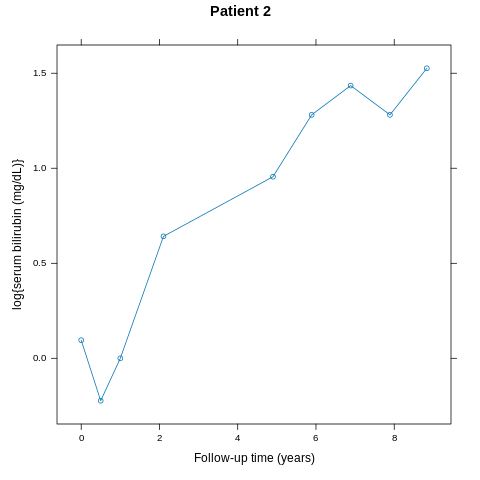

In [ ]:
%%R
# Visualize longitudinal trajectory for a specific patient (e.g., id = 2)
xyplot(log(serBilir) ~ year, data = pbc2, subset = id == 2, type = "b",
       xlab = "Follow-up time (years)", ylab = "log{serum bilirubin (mg/dL)}",
       main = "Patient 2")

### Compute Risk Difference for Patient 2


We compute the risk difference for the composite event between the active treatment (D-penicillamine) and placebo at the prediction horizon $t_{\text{horiz}} = 6$ years, using the patient’s longitudinal measurements available up to $t_0 = 4$ years. To do this, we construct a dataset containing this patient’s observed data. Since the patient was originally assigned to D-penicillamine, we also generate a counterfactual version of her data in which the `drug` variable is set to placebo.


In [ ]:
%%R
t0 <- 4
t_horiz <- 6
dataP2_Dpenici <- pbc2[pbc2$id == 2 & pbc2$year <= t0, ]
dataP2_Dpenici$years <- t0
dataP2_Dpenici$status2 <- 0

dataP2_placebo <- dataP2_Dpenici
dataP2_placebo$drug <- factor("placebo", levels = levels(pbc2$drug))


Now we use the `predict()` function to compute the predicted survival probabilities at the horizon time $t_{\text{horiz}} = 6$ years under both treatment regimes.


In [ ]:
%%R
# Predict survival probabilities under both treatment regimes
Pr1 <- predict(jmFit, newdata = dataP2_Dpenici, process = "event",
               times = t_horiz, return_mcmc = TRUE)


We produce the same estimate under the placebo arm:


In [ ]:
%%R
Pr0 <- predict(jmFit, newdata = dataP2_placebo, process = "event",
               times = t_horiz, return_mcmc = TRUE)



The estimated risk difference and its 95% credible interval are calculated by the corresponding elements of the Pr1 and Pr0 objects, i.e.,


In [ ]:
%%R
# estimate
Pr1$pred[2L] - Pr0$pred[2L]
# MCMC variability
quantile(Pr1$mcmc[2L, ] - Pr0$mcmc[2L, ], probs = c(0.025, 0.975))


      2.5%      97.5% 
-0.1673065  0.1227180 


##  Summary and Conclusion


This tutorial demonstrated how to estimate **conditional causal effects** using joint models fitted with the `{JMbayes2}` R package. By comparing predicted survival probabilities under different treatment regimes for a specific patient, we can assess the impact of treatments while accounting for time-varying confounders through the longitudinal process. This approach provides a powerful framework for causal inference in longitudinal studies with complex data structures.



## Resources


1. **Official Vignette**:

   [Causal Effects with JMbayes2](https://drizopoulos.github.io/JMbayes2/articles/Causal_Effects.html)

2. **Source Code Example**:  

   [causal_effects.R](https://github.com/drizopoulos/JMbayes2/blob/master/Development/CI/causal_effects.R)

3. **Key References**:

   - Rizopoulos, D. (2012). *Joint Models for Longitudinal and Time-to-Event Data*. Chapman & Hall.
   - Rizopoulos, D. (2021). *JMbayes2: Extended Joint Models for Longitudinal and Time-to-Event Data*. R package.
   - Keogh, R. H., & Morris, R. W. (2019). *Causal inference with joint models*. Statistical Methods in Medical Research.

